## *E. coli* pathway occupancy, Extended Data Fig 8 a and d

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy as scipy
import math 
from tqdm.auto import tqdm
import re

In [2]:
#don't print warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
#read in proteomics datasets 
ecoli_proteomics = pd.read_csv('./data/2024_01_04_ecoli_proteomics_full.csv')

#read in gene inclusion list for fermentation and respiration
ecoli_inclusion = pd.read_csv('./data/ecoli_inclusion.csv')

#read in ecoli accession number df
ecoli_gene_accession = pd.read_csv('./data/ecoli_gene_accession.csv')
ecoli_gene_accession = ecoli_gene_accession[['Gene Name', 'Accession']]
ecoli_gene_accession.rename(columns = {'Gene Name':'Gene name'}, inplace = True)

#read in metadata for ecolidatasets 
ecoli_meta = pd.read_csv('./data/2023_01_03_ecoli_metadata.csv')
ecoli_meta.rename(columns = {'column_title':'variable'}, inplace = True)

In [4]:
#get the dataset names for melt function
dataset_name = [col for col in ecoli_proteomics.columns if col not in ['Accession', 'Unnamed: 0']]
#use melt funtion to put data table into correct format 
ecoli_proteomics_melt = pd.melt(ecoli_proteomics, id_vars=['Accession'],
                                 value_vars=dataset_name)

In [5]:
#merge together the proteomics datasets with the metadata and accession number
ecoli_proteomics_melt = pd.merge(pd.merge(ecoli_proteomics_melt, ecoli_meta, on='variable', how='left'), ecoli_gene_accession, on='Accession', how='left')

In [6]:
#remove non-mass spec datasets
ecoli_proteomics_melt = ecoli_proteomics_melt.loc[~(ecoli_proteomics_melt['author'] == 'li')]

### ETC Correction

In [7]:
#subsetting the inclusion list that needs to be corrected
total_inclusion = pd.merge(ecoli_inclusion[['Gene name', 'pathway', 'MW']], ecoli_proteomics_melt, on = 'Gene name', how = 'left')

In [8]:
#selecting the ETC genes
total_inclusion_etc = total_inclusion.loc[total_inclusion['Gene name'].str.contains('nuo|cyo|cyd|atp')]

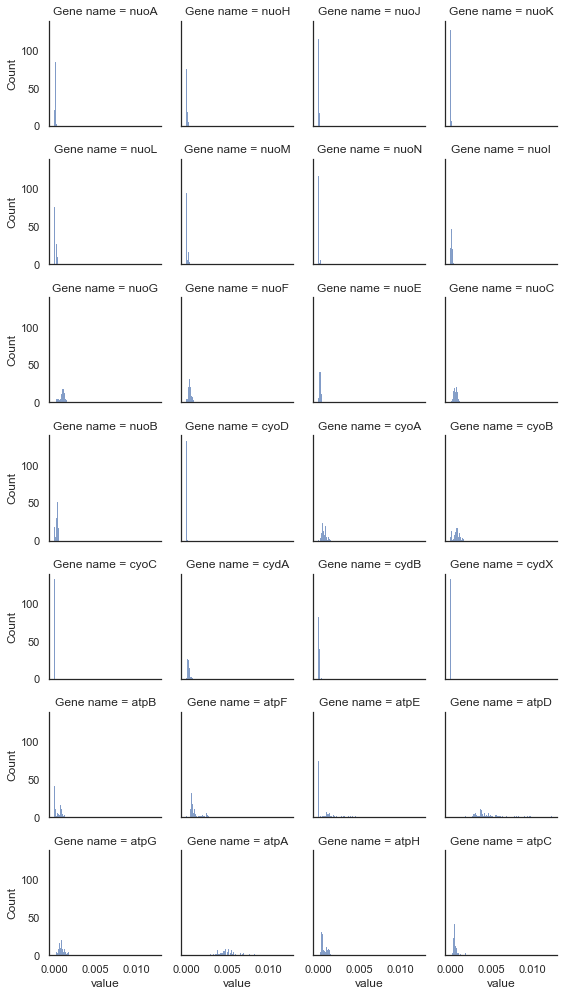

In [9]:
#plotting histograms of the occupancy of etc genes (large bars at 0 are genes that will be corrected)
sns.set_theme(style="white")
sns.displot(
    total_inclusion_etc, x="value", col="Gene name",
    height=2, facet_kws=dict(margin_titles=True),
    col_wrap=4)

In [10]:
#calculate the fraction of 'value' <= 0.00001 for each 'Gene name'
fractions = total_inclusion_etc.groupby('Gene name')['value'].apply(lambda x: (x <= 0.00001).mean())

#create a df from the fractions
df_zero = fractions.reset_index(name='Fraction Zero')

#determine which genes meet the criteria (less than 20 percent 0 occupancy)
geneCorrect = fractions[fractions >= 0.2].index.tolist()
geneTruth = fractions[fractions < 0.2].index.tolist()

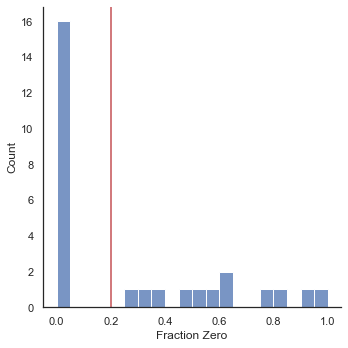

In [11]:
#hist
sns.set_theme(style="white")
sns.displot(
    df_zero, x="Fraction Zero", bins = 20)
plt.axvline(0.2, color='r')

In [12]:
#find geneTruth to filter dataset 
dataset_filtered = total_inclusion_etc[total_inclusion_etc['Gene name'].isin(geneTruth)]

#calculate correction value 
dataset_filtered['correction_value'] = dataset_filtered['value'] / dataset_filtered['MW']

#create the df with correction values
df = dataset_filtered[['variable', 'Gene name', 'correction_value']].copy()

In [13]:
#gene groups that will be corrected (etc complexes)
gene_list = ['nuo', 'cyo', 'cyd', 'atp']

#create a new column to identify the gene group based on gene_list
df['Gene group'] = df['Gene name'].apply(lambda x: next((gene for gene in gene_list if gene in x), None))

#filter out nas
df_filtered = df.dropna(subset=['Gene group'])

#groupby variable and gene group', then calculate the mean correction value
df_correction = df_filtered.groupby(['variable', 'Gene group'])['correction_value'].mean().reset_index()

In [14]:
#replace missing etc values 

#create a mapping of genes in geneCorrect that match any in gene_list to their simplified gene name
gene_mapping = {gene: next((g for g in gene_list if g in gene), None) for gene in geneCorrect}

#add a simplified gene name column to dataset for matching
total_inclusion_etc['Simplified Gene Name'] = total_inclusion_etc['Gene name'].map(gene_mapping)

#merge dataset with df_correction 
merged_dataset = pd.merge(total_inclusion_etc, df_correction, left_on=['variable', 'Simplified Gene Name'], right_on=['variable', 'Gene group'], how='left')

#calculate corrected_value
merged_dataset['corrected_value'] = merged_dataset['correction_value'] * merged_dataset['MW']

#make a copy of merged_dataset
df_final = merged_dataset.copy()

#drop na in corrected_value
df_final = df_final.dropna(subset=['corrected_value'])

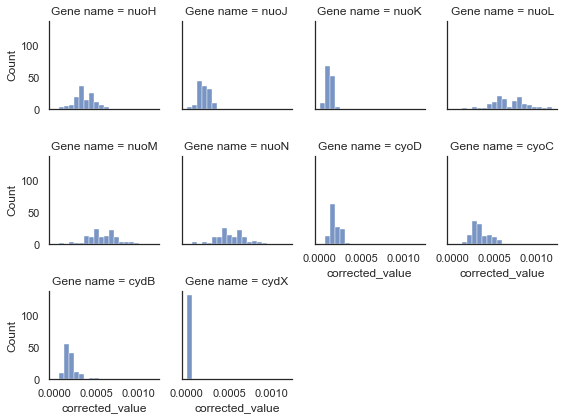

In [15]:
#plot corrected genes
sns.set_theme(style="white")
sns.displot(
    df_final.loc[~(df_final['Gene name'].str.contains('atp'))], x="corrected_value", col="Gene name",
    height=2, facet_kws=dict(margin_titles=True),
    col_wrap=4)

In [16]:
#replace orginal values with corrected etc values
for accession in list(df_final['Accession'].unique()):
    for variable in list(df_final['variable'].unique()):
        df_temp = df_final.loc[(df_final['variable'] == variable) & (df_final['Accession'] == accession)]
        #print(df_temp)
        #print(ecoli_proteomics.loc[ecoli_proteomics['Accession'] == accession,variable])
        ecoli_proteomics.loc[ecoli_proteomics['Accession'] == accession,variable] = df_temp['corrected_value'].values
    
ecoli_proteomics_accession = ecoli_proteomics['Accession']
    
ecoli_proteomics_test = ecoli_proteomics.drop(['Accession'], axis=1)
    
replacement_etc = (ecoli_proteomics_test / ecoli_proteomics_test.sum())
    
ecoli_proteomics = pd.concat([replacement_etc, ecoli_proteomics_accession], axis=1)

## Pathway Occupancy

### Fermentation and Pta-Ack pathway

In [17]:
#read in gene inclusion list for fermentation and respiration
ecoli_inclusion = pd.read_csv('./data/ecoli_inclusion.csv')

In [18]:
#subset to ferm genes
ecoli_inclusion_ferm_anaerobic = ecoli_inclusion.loc[ecoli_inclusion['meta_pathway'] == 'fermentation']

In [19]:
#subset to ferm genes (will eventually add the appropriate etc genes)
ecoli_inclusion_ferm = ecoli_inclusion.loc[ecoli_inclusion['meta_pathway'] == 'fermentation']

In [20]:
#subset to resp genes
ecoli_inclusion_resp = ecoli_inclusion.loc[ecoli_inclusion['meta_pathway'] == 'respiration']

In [21]:
#Add ETC proteins to the Pta-Ack pathway
#Note the high-yielding pathway is used here

#High yielding
ferm_etc_inclusion_list = ['nuo', 'cyo', 'aceE', 'aceF', 'atpB', 'atpF', 'atpE', 'atpD', 'atpG', 'atpA', 'atpH', 'atpC']
#Low yielding 
#ferm_etc_inclusion_list = ['ndh', 'cyo']
#No ETC
#ferm_etc_inclusion_list = []

fermentation_etc = pd.DataFrame()
for gene in ferm_etc_inclusion_list: 
    output = ecoli_inclusion_resp.loc[ecoli_inclusion_resp['Gene name'].str.contains(gene)]
    fermentation_etc['meta_pathway'] = 'fermentation'
    fermentation_etc = pd.concat([fermentation_etc, output])

ecoli_inclusion_ferm = pd.concat([ecoli_inclusion_ferm, fermentation_etc])

In [22]:
#merge the proteomics data with the inclusion list 
ecoli_proteomics_ferm_inclusion_final = pd.merge(ecoli_inclusion_ferm, ecoli_proteomics, on = 'Accession', how = 'left')

In [23]:
#use melt funtion to put data table into correct format 
column_list = np.array([col for col in ecoli_proteomics.columns if col not in ['Accession', 'Unnamed: 0']])

#note that only the fermentable carbon sources were used
ecoli_proteomics_ferm_melt = pd.melt(ecoli_proteomics_ferm_inclusion_final, id_vars=['Gene name', 'pathway'],
                                 value_vars=column_list)

In [24]:
#merge proteomics data with the meta data
ecoli_proteomics_ferm_melt = pd.merge(ecoli_proteomics_ferm_melt, ecoli_meta, on = 'variable', how = 'left')


In [25]:
#use only the fermentable carbon sources from batch culture for fermentation specific activity
ecoli_proteomics_ferm_melt_sa = ecoli_proteomics_ferm_melt.loc[(ecoli_proteomics_ferm_melt['author'] == 'schmidt') 
                                                             & (ecoli_proteomics_ferm_melt['carbon_source_cat'] == 'fermentable') 
                                                             & (ecoli_proteomics_ferm_melt['method'] == 'batch')]

In [26]:
#make a copy that will not get biomass corrected for comparision
ecoli_proteomics_ferm_melt_sa_no_biomass_correction = ecoli_proteomics_ferm_melt_sa.copy()

#### Fermentaion biomass producing fraction

In [27]:
#read in the fraction to biomass data
ecoli_biomass = pd.read_csv('./data/2022_11_06_ecoli_biomass.csv')

#fraction of carbon dedicated to producing biomass
ecoli_biomass_ferm_mean = ecoli_biomass[ecoli_biomass['Condition'] == 'Fermentation']['Fraction '].mean()

In [28]:
#correction applies to only the enzymes in glycolysis
ecoli_proteomics_ferm_melt_sa.loc[(ecoli_proteomics_ferm_melt_sa['media'] == 'minimal') & 
                                  (ecoli_proteomics_ferm_melt_sa['pathway'] == 'glycolysis'), 
                                  'value'] = ecoli_proteomics_ferm_melt_sa['value'] * (1-ecoli_biomass_ferm_mean)

#### Fermentation

In [29]:
#select only the genes in for anaerobic fermentation
ecoli_proteomics_fermentation_no_ETC = ecoli_proteomics_ferm_melt_sa.loc[
    ecoli_proteomics_ferm_melt_sa['pathway'].isin(['glycolysis', 'pyruvate', 'fermentation'])]

In [30]:
#drop duplicates
ecoli_proteomics_fermentation_no_ETC = ecoli_proteomics_fermentation_no_ETC.drop_duplicates()

In [31]:
#groupby dataset variable and sum the entire set of genes for final sum
ecoli_proteomics_ferm_no_ETC_sum = ecoli_proteomics_fermentation_no_ETC.groupby('variable').sum().reset_index().assign(
    estimate='fermentation', organism='ecoli')

In [32]:
#average occupancy
ecoli_proteomics_ferm_no_ETC_sum['value'].mean()

0.05648406405552262

In [33]:
#save df
ecoli_proteomics_ferm_no_ETC_sum.to_csv('Data/2024_02_22_ecoli_specific_activity_fermentation_no_ETC_occupancy.csv')

#### Pta-ack

In [34]:
#drop duplicates
ecoli_proteomics_ferm_melt_sa = ecoli_proteomics_ferm_melt_sa.drop_duplicates()

In [35]:
#groupby dataset variable and sum the entire set of genes for final sum
ecoli_proteomics_ferm_inclusion_final_gene_sum = ecoli_proteomics_ferm_melt_sa.groupby('variable').sum().reset_index().assign(estimate = 'fermentation', organism='ecoli')



In [36]:
#average occupancy
ecoli_proteomics_ferm_inclusion_final_gene_sum['value'].mean()

0.08070300291611603

In [37]:
#save df
ecoli_proteomics_ferm_inclusion_final_gene_sum.to_csv('Data/2024_02_22_ecoli_specific_activity_fermentation.csv')

In [38]:
#calculate occupancy for df that was not biomass corrected
ecoli_proteomics_ferm_melt_sa_no_biomass_correction.drop_duplicates(inplace = True)
ecoli_proteomics_ferm_melt_sa_no_biomass_correction.groupby('variable').sum().reset_index().assign(estimate = 'fermentation', organism='ecoli')['value'].mean()

0.10896412845366836

In [39]:
#calculate mean values
mean_initial = ecoli_proteomics_ferm_melt_sa_no_biomass_correction.groupby('variable').sum().reset_index().assign(estimate = 'fermentation', organism='ecoli')['value'].mean()
mean_final = ecoli_proteomics_ferm_inclusion_final_gene_sum['value'].mean()

#calculate percent decrease
percent_decrease = (mean_initial - mean_final) / mean_initial * 100

#print proteome occupancy decrease from biomass correction
message = "Percent decrease = {:.2f}%".format(percent_decrease)
message

'Percent decrease = 25.94%'

### Respiration pathway

In [40]:
#subset to resp genes
ecoli_inclusion_resp = ecoli_inclusion.loc[ecoli_inclusion['meta_pathway'] == 'respiration']

In [41]:
#merge the proteomics data with the inclusion list 
ecoli_proteomics_resp_inclusion_final = pd.merge(ecoli_inclusion_resp, ecoli_proteomics, on = 'Accession', how = 'left')

In [42]:
#melt df
ecoli_proteomics_resp_melt = pd.melt(ecoli_proteomics_resp_inclusion_final, id_vars=['Gene name', 'pathway'],
                                 value_vars=column_list)

In [43]:
#merge proteomics data with the meta data
ecoli_proteomics_resp_melt = pd.merge(ecoli_proteomics_resp_melt, ecoli_meta, on = 'variable', how = 'left')

In [44]:
#use only the nonfermentable carbon sources from batch culture for fermentation specific activity
ecoli_proteomics_resp_melt_sa = ecoli_proteomics_resp_melt.loc[(ecoli_proteomics_resp_melt['author'] == 'schmidt') 
                               & (ecoli_proteomics_resp_melt['carbon_source_cat'] == 'nonfermentable') 
                               & (ecoli_proteomics_resp_melt['method'] == 'batch')]

In [45]:
#make a copy that will not get biomass corrected for comparision
ecoli_proteomics_resp_melt_sa_no_biomass_correction = ecoli_proteomics_resp_melt_sa.copy()

#### Respiration Biomass producing fraction

In [46]:
#read in the fraction to biomass spreadsheet
ecoli_biomass = pd.read_csv('./data/2022_11_06_ecoli_biomass.csv')

In [47]:
#subset to resp genes
ecoli_biomass_resp = ecoli_biomass.loc[ecoli_biomass['Condition'] == 'Respiration']

In [48]:
ecoli_biomass_resp_mean = ecoli_biomass_resp['Fraction '].mean()
ecoli_biomass_resp_mean

0.40945241093333334

In [49]:
ecoli_pathway_list = ecoli_inclusion[['pathway', 'Gene name']]

In [50]:
#correction applies to only the enzymes in the tca cycle
ecoli_proteomics_resp_melt_sa.loc[(ecoli_proteomics_resp_melt_sa['media'] == 'minimal') & 
                                  (ecoli_proteomics_resp_melt_sa['pathway'] == 'tca') , 
                                  'value'] = ecoli_proteomics_resp_melt_sa['value'] * (1-ecoli_biomass_resp_mean)

#### Respiration

In [51]:
#drop duplicates
ecoli_proteomics_resp_melt_sa = ecoli_proteomics_resp_melt_sa.drop_duplicates()

In [52]:
#groupby dataset variable and sum the entire set of genes for final sum
ecoli_proteomics_resp_inclusion_final_gene_sum = ecoli_proteomics_resp_melt_sa.groupby('variable').sum().reset_index().assign(estimate = 'respiration', organism = 'ecoli')


In [53]:
#mean occupancy
ecoli_proteomics_resp_inclusion_final_gene_sum['value'].mean()

0.11203320246301977

In [54]:
#save df
ecoli_proteomics_resp_inclusion_final_gene_sum.to_csv('./data/2024_02_22_ecoli_specific_activity_respiration.csv')

In [55]:
#calculate occupancy for df that was not biomass corrected
ecoli_proteomics_resp_melt_sa_no_biomass_correction.drop_duplicates(inplace = True)
ecoli_proteomics_resp_melt_sa_no_biomass_correction.groupby('variable').sum().reset_index().assign(estimate = 'respiration', organism = 'ecoli')['value'].mean()

0.16129742367788766

In [56]:
#calculate mean values
mean_initial = ecoli_proteomics_resp_melt_sa_no_biomass_correction.groupby('variable').sum().reset_index().assign(estimate = 'respiration', organism = 'ecoli')['value'].mean()
mean_final = ecoli_proteomics_resp_inclusion_final_gene_sum['value'].mean()

#calculate percent decrease
percent_decrease = (mean_initial - mean_final) / mean_initial * 100

#print proteome occupancy decrease from biomass correction
message = "Percent decrease = {:.2f}%".format(percent_decrease)
print(message)

Percent decrease = 30.54%


### ATP-producing pathways

In [57]:
#inclusion list for all atp-producing genes
ecoli_inclusion = ecoli_inclusion[['Gene name', 'pathway', 'Accession']]

In [58]:
#merge with proteomics data
ecoli_proteomics_full_pathway = pd.merge(ecoli_inclusion, ecoli_proteomics, on = 'Accession', how = 'left')

In [59]:
#use melt funtion to put data table into correct format 
ecoli_proteomics_full_melt = pd.melt(ecoli_proteomics_full_pathway, id_vars=['Gene name', 'pathway'],
                                 value_vars=column_list)

In [60]:
ecoli_proteomics_full_melt = pd.merge(ecoli_proteomics_full_melt, ecoli_meta, on = 'variable', how = 'left')

In [61]:
#biomass correction: correction applies to only the enzymes in glycolysis and tca cycle
ecoli_proteomics_full_melt.loc[(ecoli_proteomics_full_melt['media'] == 'minimal') & 
                                  (ecoli_proteomics_full_melt['carbon_source_cat'] == 'fermentable') &
                                  (ecoli_proteomics_full_melt['pathway'] == 'tca'), 
                                  'value'] = ecoli_proteomics_full_melt['value'] * (1-ecoli_biomass_ferm_mean)

ecoli_proteomics_full_melt.loc[(ecoli_proteomics_full_melt['media'] == 'minimal') & 
                                  (ecoli_proteomics_full_melt['carbon_source_cat'] == 'fermentable') &
                                  (ecoli_proteomics_full_melt['pathway'] == 'glycolysis'), 
                                  'value'] = ecoli_proteomics_full_melt['value'] * (1-ecoli_biomass_ferm_mean)

ecoli_proteomics_full_melt.loc[(ecoli_proteomics_full_melt['media'] == 'minimal') & 
                                  (ecoli_proteomics_full_melt['carbon_source_cat'] == 'nonfermentable') &
                                  (ecoli_proteomics_full_melt['pathway'] == 'tca'), 
                                  'value'] = ecoli_proteomics_full_melt['value'] * (1-ecoli_biomass_resp_mean)

ecoli_proteomics_full_melt.loc[(ecoli_proteomics_full_melt['media'] == 'minimal') & 
                                  (ecoli_proteomics_full_melt['carbon_source_cat'] == 'nonfermentable') &
                                  (ecoli_proteomics_full_melt['pathway'] == 'glycolysis'), 
                                  'value'] = ecoli_proteomics_full_melt['value'] * (1-ecoli_biomass_resp_mean)

In [62]:
#copy to another name
ecoli_all = ecoli_proteomics_full_melt

In [63]:
#drop duplicates
ecoli_all = ecoli_all.drop_duplicates()

In [64]:
#groupby dataset variable and sum the entire set of genes for final sum
ecoli_proteomics_sum_total = ecoli_all.groupby('variable').sum()

In [65]:
#mean occupancy
ecoli_proteomics_sum_total['value'].mean()

0.12440515231088653

In [66]:
#save sf
ecoli_proteomics_sum_total.to_csv('./data/2024_02_22_ecoli_atp_total.csv')

### Translation Occupancy

In [67]:
#translation inclusion list
ecoli_translation_inclusion = pd.read_csv('./data/2024_01_27_ecoli_translation.csv')
ecoli_translation_inclusion.rename(columns = {'Gene': 'Gene name'}, inplace = True)

In [68]:
#merge the inclusion list with the gene accession
ecoli_translation_inclusion = pd.merge(ecoli_translation_inclusion, ecoli_gene_accession, on='Gene name', how='left')

In [69]:
#ensuring that everything merged
ecoli_translation_inclusion.isnull().sum().sum()

0

In [70]:
#merge the proteomics data with the inclusion list 
ecoli_proteomics_translation = pd.merge(ecoli_translation_inclusion, ecoli_proteomics, on = 'Accession', how = 'inner')

In [71]:
#melt df 
ecoli_proteomics_translation_melt = pd.melt(ecoli_proteomics_translation, id_vars=['Gene name'],
                                 value_vars=column_list)

In [72]:
#drop duplicates
ecoli_proteomics_translation_melt = ecoli_proteomics_translation_melt.drop_duplicates()

In [73]:
#groupby dataset variable and sum the entire set of genes for final sum
ecoli_proteomics_translation_sum = ecoli_proteomics_translation_melt.groupby('variable').sum().reset_index()

In [74]:
#ecoli_proteomics_translation_sum.reset_index(inplace = True)

In [75]:
#subsetting for mori
mori_sum = ecoli_proteomics_translation_sum.loc[ecoli_proteomics_translation_sum['variable'].str.contains('mori')]

In [76]:
#subsetting for C-limitation
mori_carbon = mori_sum.loc[(mori_sum['variable'].str.contains('C-limitation')) | (mori_sum['variable'].str.contains('calibration'))]

In [77]:
#extract the number after "μ=" and create a new column
mori_carbon['growth_rate'] = mori_carbon['variable'].str.extract(r'μ=([0-9.]+)')

#convert the extracted column to a numeric type if necessary
mori_carbon['growth_rate'] = pd.to_numeric(mori_carbon['growth_rate'])


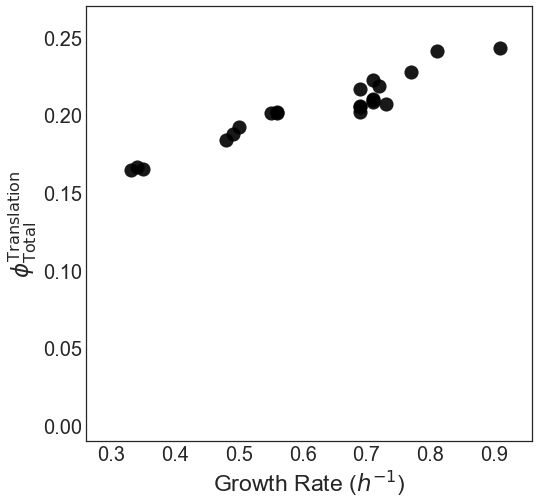

In [78]:
#plot translation occupancy vs. growth rate
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

sns.scatterplot(mori_carbon['growth_rate'], mori_carbon['value'], color = 'black', alpha=.9, linewidth = 0, s=200, zorder = 3)

ax.set_ylim(-0.01, 0.27)
ax.set_xlim(.26, 0.96)
#axis format
ax.set_xlabel("Growth Rate " + r'($h^{-1}$)', fontsize=23)
ax.set_ylabel(r"$\phi_{\mathrm{Total}}^{\mathrm{Translation}}$", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=20, length=0)

#save figure
fig.savefig('./Figures/ecoli_total_translation.svg',format='svg', dpi=1200)

In [79]:
#resetting the index
ecoli_proteomics_sum_total_reset = ecoli_proteomics_sum_total.reset_index()

#filtering rows based on c-limitation of control (calibration)
mori_carbon_atp = ecoli_proteomics_sum_total_reset[
    (ecoli_proteomics_sum_total_reset['variable'].str.contains('C-limitation')) |
    (ecoli_proteomics_sum_total_reset['variable'].str.contains('calibration'))
]

In [80]:
#extract the number after "μ=" and create a new column
mori_carbon_atp['growth_rate'] = mori_carbon_atp['variable'].str.extract(r'μ=([0-9.]+)')

#convert the extracted column to numeric
mori_carbon_atp['growth_rate'] = pd.to_numeric(mori_carbon_atp['growth_rate'])

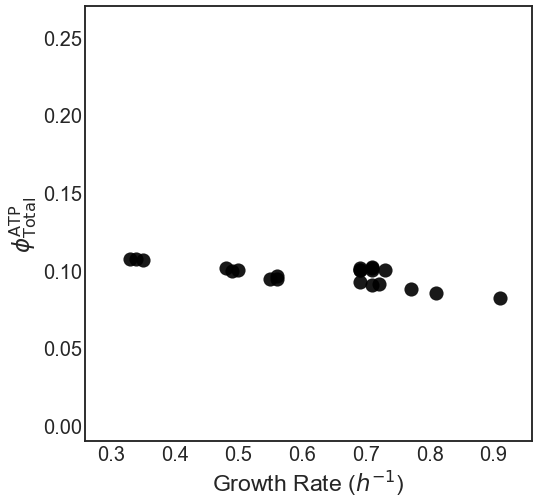

In [81]:
#plot atp-producing occupancy vs. growth rate
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

sns.scatterplot(mori_carbon_atp['growth_rate'], mori_carbon_atp['value'], color = 'black', alpha=.9, linewidth = 0, s=200, zorder = 3)

ax.set_ylim(-0.01, 0.27)
ax.set_xlim(.26, 0.96)
#axis format
ax.set_xlabel("Growth Rate " + r'($h^{-1}$)', fontsize=23)
ax.set_ylabel(r"$\phi_{\mathrm{Total}}^{\mathrm{ATP}}$", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=20, length=0)

#save figure
fig.savefig('./Figures/ecoli_total_atp_growth.svg',format='svg', dpi=1200)